In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import json
plt.rcParams["figure.figsize"] = (20,10)

## Chargement des prix au format .json

In [99]:
def prices_goat(card):
    r = requests.get("https://www.goatbots.com/card/ajax_card?search_name=" + card)
    prices = r.json()[1][0]
    d = pd.DataFrame(prices, columns = ["Date", "Sell price"])
    d['Date'] = pd.to_datetime(d['Date'])
    d = d.set_index('Date')
    return d

In [100]:
prices = prices_goat("scalding-tarn")

TypeError: __init__() got an unexpected keyword argument 'parse_dates'

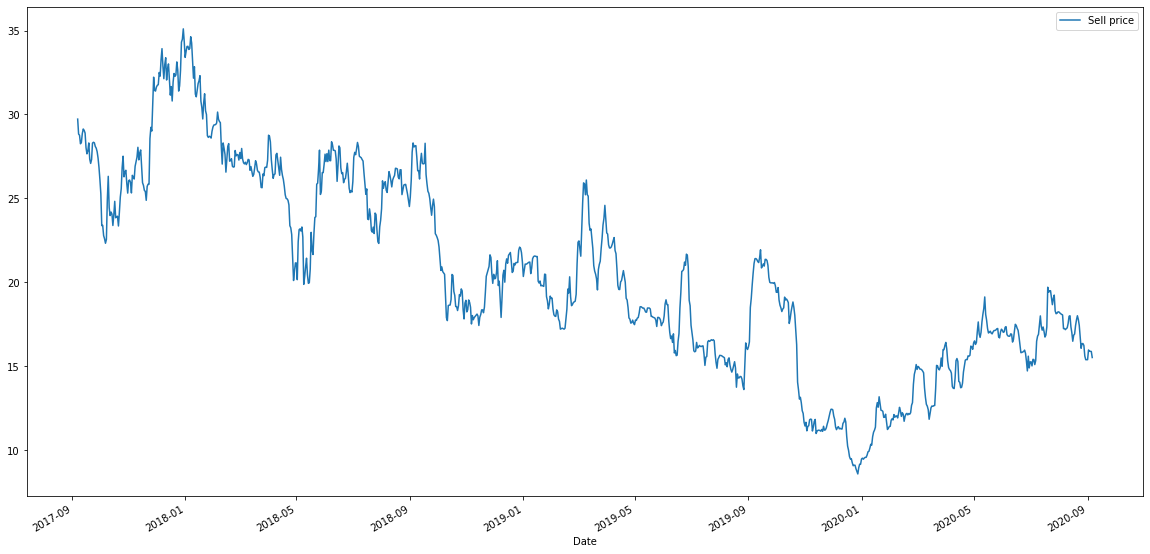

In [98]:
prices.plot()

In [105]:
!pip install fbprophet
from fbprophet import Prophet

  Running setup.py clean for fbprophet
  Created wheel for holidays: filename=holidays-0.10.3-py3-none-any.whl size=115859 sha256=63305abdb35ba2055a4b44a91c3c9e8901fc80ba1b4aa8bb98f6555d3e5c30a1
  Stored in directory: c:\users\quent\appdata\local\pip\cache\wheels\a2\97\85\fd3fe9e0f96120582caa3470bde6652f826b4e5842e3cce65c
  Created wheel for pymeeus: filename=PyMeeus-0.3.7-py3-none-any.whl size=702883 sha256=107543ad2426c19984776bbfab67f33443a8ff892025a2a535b8f59c2fbaca77
  Stored in directory: c:\users\quent\appdata\local\pip\cache\wheels\5a\68\50\d989a005ecd4f58a7922bede25ff7e391d66395a3090acf97a
Successfully built holidays pymeeus
Failed to build fbprophet
    Running setup.py install for fbprophet: started
    Running setup.py install for fbprophet: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Quent\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Quent\\AppData\\Local\\Temp\\pip-install-0v01i78t\\fbprophet\\setup.py'"'"'; __file__='"'"'C:\\Users\\Quent\\AppData\\Local\\Temp\\pip-install-0v01i78t\\fbprophet\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Quent\AppData\Local\Temp\pip-wheel-8evn_e4f'
       cwd: C:\Users\Quent\AppData\Local\Temp\pip-install-0v01i78t\fbprophet\
  Complete output (44 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "C:\Users\Quent\AppData\Local\Temp\pip-install-0v01i78t\fb

ModuleNotFoundError: No module named 'fbprophet'


            with
            [
                F=stan::math::internal::softmax_op
            ]
    C:\Users\Quent\anaconda3\lib\site-packages\pystan\stan\lib\stan_math\stan/math/rev/mat/functor/adj_jac_apply.hpp(414): note: Raisonÿ: impossible de convertir de 'Eigen::VectorXd' en 'const double'
    C:\Users\Quent\anaconda3\lib\site-packages\pystan\stan\lib\stan_math\stan/math/rev/mat/functor/adj_jac_apply.hpp(414): note: Aucun op‚rateur de conversion d‚finie par l'utilisateur disponible qui puisse effectuer cette conversion, ou l'op‚rateur ne peut pas ˆtre appel‚
    C:\Users\Quent\anaconda3\lib\site-packages\pystan\stan\lib\stan_math\stan/math/rev/mat/functor/adj_jac_apply.hpp(333): note: voir la d‚claration de 'stan::math::adj_jac_vari<F,Eigen::Matrix<stan::math::var,-1,1,0,-1,1>>::build_return_varis_and_vars'
            with
            [
                F=stan::math::internal::softmax_op
            ]
    C:\Users\Quent\anaconda3\lib\site-packages\pystan\stan\lib\stan_math\stan/